In [1]:
import os
import sys
import numpy as np
import healpy as hp
import histlite as hl
import csky as cy
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
%matplotlib inline
# %matplotlib notebook

from glob import glob
timer = cy.timing.Timer()
time = timer.time

sys.path.append('../../')
from greco_grb.scripts import SETTING
paths = SETTING.PATH()
print(paths)
USER = paths.USER
ICDATA_DIR = paths.ICDATA_DIR
DATA_DIR = paths.DATA_DIR
ANA_DIR = paths.ANA_DIR

from greco_grb.scripts.utils import *


#### Running at IceCube ####

LOCATION: 	 IceCube
USER: 	 cjchen
ICDATA_DIR: 	 /data/user/cjchen/csky/analyses/online_GRECO/candidate-002-p10
DATA_DIR: 	 /data/user/cjchen/2020-2021/Spring2021/greco_grb/data
ANA_DIR: 	 /data/user/cjchen/2020-2021/Spring2021/greco_grb/data/csky_output



In [2]:
df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHealpix_2268.pkl")

In [3]:
print("\n===== Setting up csky =====\n")
data_dir = ICDATA_DIR
data_filenames = sorted(glob(data_dir + '/IC86_20*.data.npy'))
sig_filenames = sorted(glob(data_dir + '/IC86_2012.nu*_merged.npy'))
grl_filenames = sorted(glob(data_dir + '/GRL/IC86_20*.data.npy'))

################ energy lower bound #############
min_log_e = np.log10(10)
#################################################
bins_sindec = np.linspace(-1, 1, 25+1)  
# bins_logenergy = np.linspace(min_log_e, 5, 30+1)
bins_logenergy = np.linspace(min_log_e, 4, 25+1)

data = [np.load(data_filename) for data_filename in data_filenames]
data = np.hstack(data)
sig = [np.load(sig_filename) for sig_filename in sig_filenames]
sig = np.hstack(sig)
grl = [np.load(grl_filename) for grl_filename in grl_filenames]
grl = np.hstack(grl)
if min_log_e is not None:
    data_mask = data['logE'] > min_log_e
    data = data[data_mask]
    sig_mask = sig['logE'] > min_log_e
    sig = sig[sig_mask]
    
dataset_spec = cy.selections.CustomDataSpecs.CustomDataSpec(data, sig, np.sum(grl['livetime']),
                                                     sindec_bins=bins_sindec,
                                                     logenergy_bins=bins_logenergy,
                                                     grl=grl, key='greco_v2.10', cascades=True)

ANA_DIR = cy.utils.ensure_dir(ANA_DIR)
# on OSG
# ana_dir = "./"
ana = cy.get_analysis(cy.selections.repo
                      , dataset_spec
                      , dir=ANA_DIR
                      , load_sig=True)  # to save memory: use False






===== Setting up csky =====

Setting up Analysis for:
greco_v2.10
Setting up greco_v2.10...
Energy PDF Ratio Model...
  * gamma = 4.0000 ...
Signal Acceptance Model...
  * gamma = 4.0000 ...
Done.


In [4]:
def get_trial_from_flux(flux=cy.hyp.PowerLawFlux(3)):
    conf = {
        'ana': ana,
        #### llh basics: csky.conf
        'space': 'ps', # ps/fitps/template/prior
        'time': 'transient', # utf/lc/transient
        'energy': 'customflux', # fit/customflux
        'flux': flux,
        #### inj.py - prior has some duplications against space's prior
        'sig': 'transient', # ps/tw/lc/transient/template/prior
        'full_sky': True,
        'extended': True,
        'mp_cpus': 4,
        'cut_n_sigma': 3
        }

    cy.CONF.update(conf)
    class args:
        grb_name = "GRB180423A"    # real healpix example
        # grb_name = "GRB190415A"    # fake healpix example
        n_inj = 1e6
        batchNtrials = 1
        tw_in_second = 500
        batchIndex = 0
        use_poisson = True
        ncpu = 4

#     print("\n===== Loading no-healpix df =====\n")
    df = pd.read_pickle(DATA_DIR+"/grbwebgbm/grbweb_gbm_noHeaplix.pkl")
    # realHealpix: df.gbm & df.hasHealpix
    # fakeHealpix: ~(df.gbm & df.hasHealpix)
    df.head()

#     print("\n===== Loading healpix of {}=====\n".format(args.grb_name))   
    try:
        healpix = np.load(DATA_DIR+"/grbwebgbm/healpix/{}_healpix_nside64.npy".format(args.grb_name))
        # healpix can contain negative values: faults due to Fermi-GBM
        healpix = np.maximum(healpix,0)
        ########## healpix reduce ##########
        healpix[healpix < isf_healpix(healpix, q=0.99)] = 0
    except:
        raise Exception("Cannot load the healpix for grb: {}\n".format(args.grb_name))

    grb_row = df.loc[df['grb_name'] == args.grb_name]
    tw = args.tw_in_second/86400.
    tw_start = grb_row.t_center - 0.5*tw
    ra = grb_row.ra
    dec = grb_row.dec
#     print("\n...Done\n")

    src = cy.sources(
        ra=ra,
        dec=dec,
        deg=True,
        mjd=tw_start, 
        sigma_t=np.zeros_like(tw), 
        t_100=tw,  # in days
        prior=[hl.heal.HealHist(healpix)],
        name=args.grb_name
    )
    seed = abs(java_hash(src.name[0]+"_signal_batchIndex{}".format(args.batchIndex)))
    sptr = cy.get_spatial_prior_trial_runner(conf=cy.CONF
                                             ,src_tr=src
                                             ,llh_priors=[healpix]
                                             ,cut_n_sigma=5.) # src_tr is must for transient

    trial = sptr.get_one_trial(n_sig=args.n_inj, poisson=args.use_poisson, seed=1)
    print("200 OK")
    return trial


In [5]:
trial_gamma2 = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(2))
trial_gamma2dot5 = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(2.5))
trial_gamma3 = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(3))
trial_sps20 = get_trial_from_flux(flux=cy.hyp.SubphotosphericFlux(20))
trial_sps100 = get_trial_from_flux(flux=cy.hyp.SubphotosphericFlux(100))

trial_gamma2_300cutoff = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(2, energy_cutoff=300))
trial_gamma2dot5_300cutoff = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(2.5, energy_cutoff=300))
trial_gamma3_300cutoff = get_trial_from_flux(flux=cy.hyp.PowerLawFlux(3, energy_cutoff=300))


200 OK
200 OK
200 OK
float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


200 OK
float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


float64


/storage/hive/project/phy-taboada/cchen641/icecube/software/csky/csky/hyp.py:279: RuntimeWarning: overflow encountered in exp
  np.power(E/kT, 2.)/(np.exp(E/kT) +1.), 0)


200 OK
200 OK
200 OK
200 OK


In [6]:
def get_h_from_trial(trial):
    event_energy = 10**trial.evss[0][1].log10energy

    E_bins = np.logspace(1.,4.,51)
    logE_bins = np.log10(E_bins)
    dlog_E = np.diff(logE_bins) 

    h = hl.hist(event_energy, 
                bins=E_bins)
    return h

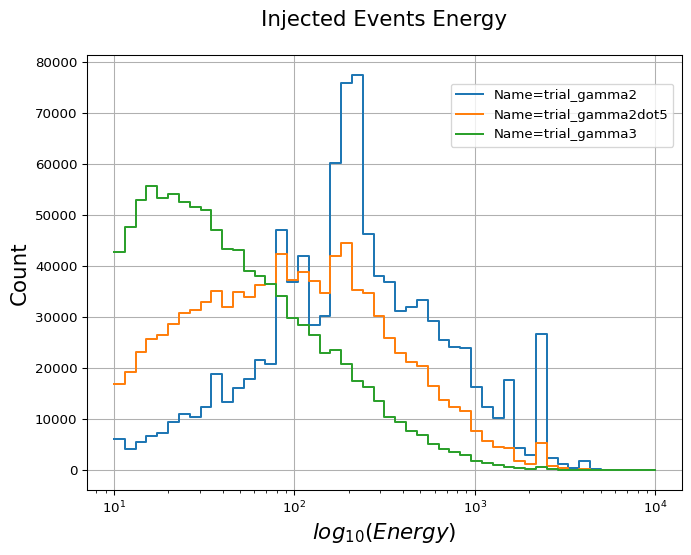

In [7]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

h = get_h_from_trial(trial_gamma2)
hl.plot1d(ax, h, label=f"Name=trial_gamma2")

h = get_h_from_trial(trial_gamma2dot5)
hl.plot1d(ax, h, label=f"Name=trial_gamma2dot5")

h = get_h_from_trial(trial_gamma3)
hl.plot1d(ax, h, label=f"Name=trial_gamma3")

ax.set_xscale('log')
ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.6, 0.95), fontsize=10)
ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

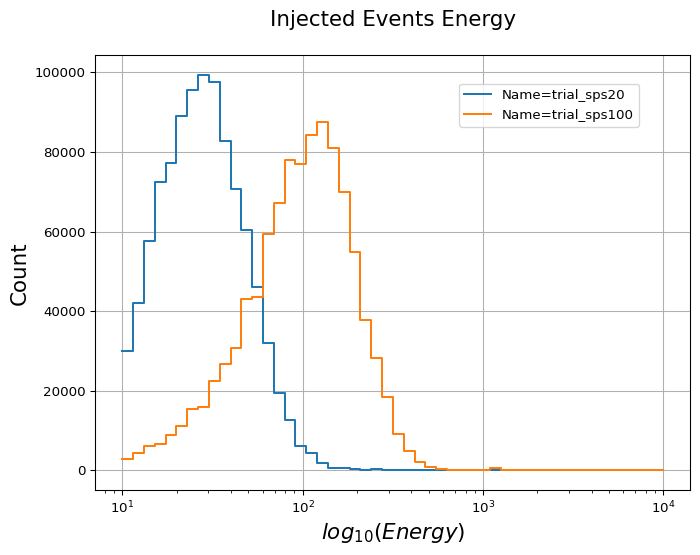

In [8]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

h = get_h_from_trial(trial_sps20)
hl.plot1d(ax, h, label=f"Name=trial_sps20")

h = get_h_from_trial(trial_sps100)
hl.plot1d(ax, h, label=f"Name=trial_sps100")

ax.set_xscale('log')
ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.6, 0.95), fontsize=10)
ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

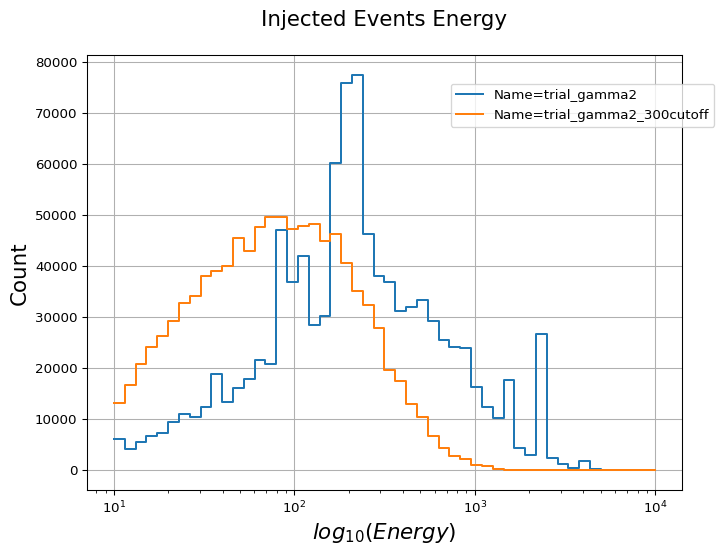

In [9]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

h = get_h_from_trial(trial_gamma2)
hl.plot1d(ax, h, label=f"Name=trial_gamma2")

h = get_h_from_trial(trial_gamma2_300cutoff)
hl.plot1d(ax, h, label=f"Name=trial_gamma2_300cutoff")

ax.set_xscale('log')
ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.6, 0.95), fontsize=10)
ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

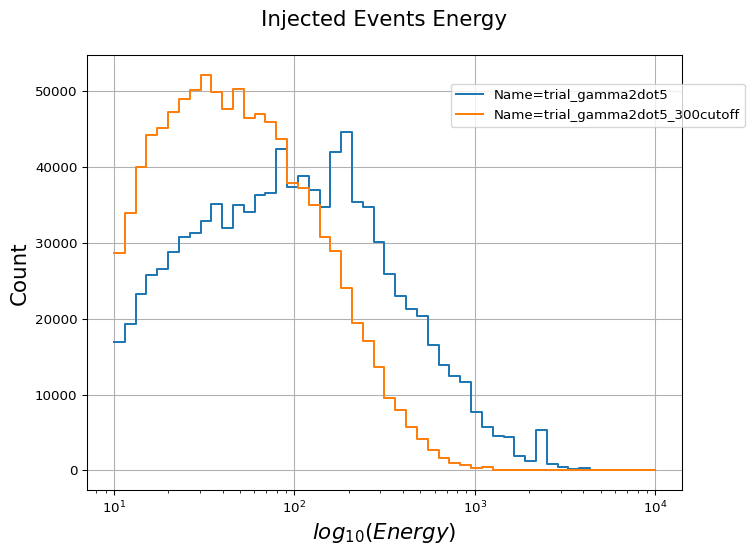

In [10]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

h = get_h_from_trial(trial_gamma2dot5)
hl.plot1d(ax, h, label=f"Name=trial_gamma2dot5")

h = get_h_from_trial(trial_gamma2dot5_300cutoff)
hl.plot1d(ax, h, label=f"Name=trial_gamma2dot5_300cutoff")

ax.set_xscale('log')
ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.6, 0.95), fontsize=10)
ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()

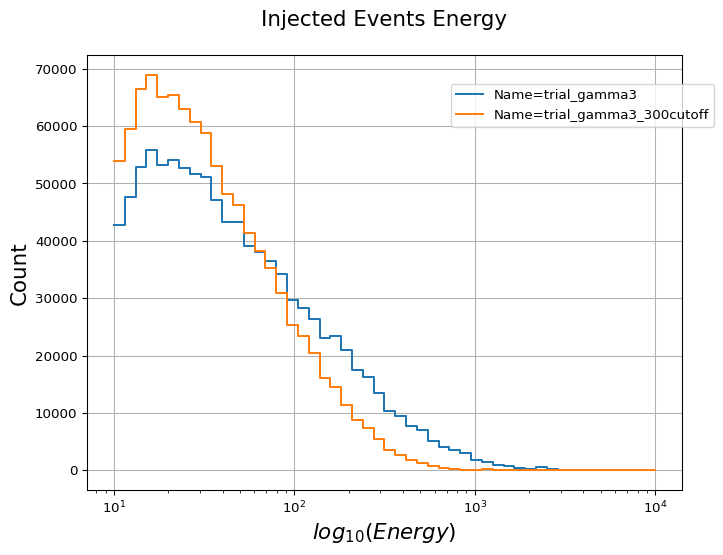

In [11]:
fig, ax = plt.subplots(figsize=(8,6), dpi=96)

h = get_h_from_trial(trial_gamma3)
hl.plot1d(ax, h, label=f"Name=trial_gamma3")

h = get_h_from_trial(trial_gamma3_300cutoff)
hl.plot1d(ax, h, label=f"Name=trial_gamma3_300cutoff")

ax.set_xscale('log')
ax.set_xlabel(r'$log_{10}(Energy)$', fontsize=16)
ax.set_ylabel("Count", fontsize=16)
ax.grid(True)
ax.legend(loc='upper left', ncol=1, bbox_to_anchor=(0.6, 0.95), fontsize=10)
ax.set_title('Injected Events Energy'.format(len(df.t100)), fontsize=16, y=1.05)
plt.show()